## Deep Q-Learning for FrozenLake

In [2]:
import sys

sys.path.append("../src/")

%load_ext autoreload
%autoreload 2

In [3]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using device: {device}")

Using device: mps


In [ ]:
# Import necessary libraries
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import seaborn as sns
import shutil
from collections import deque

import matplotlib.pyplot as plt

import cv2
import imageio
import time

from utils import show
from base_agent import BaseAgent
from summary_writer import LocalSummaryWriter
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [5]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity

        self.states = deque(maxlen=capacity)
        self.actions = deque(maxlen=capacity)
        self.next_states = deque(maxlen=capacity)
        self.rewards = deque(maxlen=capacity)
        self.dones = deque(maxlen=capacity)

    def store(self, state, action, next_state, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)

    def sample(self, batch_size):
        indices = np.random.choice(len(self), size=batch_size, replace=False)

        states = torch.stack(
            [torch.as_tensor(self.states[i], dtype=torch.float32, device=device) for i in indices]
        ).to(device)
        actions = torch.as_tensor(
            [self.actions[i] for i in indices], dtype=torch.long, device=device
        )
        next_states = torch.stack(
            [
                torch.as_tensor(self.next_states[i], dtype=torch.float32, device=device)
                for i in indices
            ]
        ).to(device)
        rewards = torch.as_tensor(
            [self.rewards[i] for i in indices], dtype=torch.float32, device=device
        )
        dones = torch.as_tensor([self.dones[i] for i in indices], dtype=torch.bool, device=device)

        return states, actions, next_states, rewards, dones

    def __len__(self):
        return len(self.dones)

In [6]:
"""Deep Q Learning Network."""


class DQN(nn.Module):
    """Deep Q Network."""

    def __init__(self, num_actions, input_dim, num_hidden=128):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, num_actions)

    def forward(self, x):
        """Forward pass through the network."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:



class DQNAgent(BaseAgent):
    """DQN Agent that interacts with and learns from the environment."""

    # local_qnetwork--> selects the action
    # target_qnetwork --> calculate target queue values in the local network
    # double queue network stablizes the learning process
    def __init__(
        self,
        env,
        num_states,
        num_actions,
        epsilon_max,
        epsilon_min,
        epsilon_decay,
        clip_grad_norm,
        learning_rate,
        discount,
        memory_capacity,
        batch_size,
        update_frequency,
        max_episodes,
        save_interval,
        save_path,
        seed,
        writer,
    ):
        self.env = env
        # To save the history of network loss
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0
        self.seed = seed

        # RL hyperparameters
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount = discount

        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.max_episodes = max_episodes
        self.save_interval = save_interval
        self.save_path = save_path
        self.num_states = num_states
        self.num_actions = num_actions

        self.action_space = env.action_space
        self.action_space.seed(
            self.seed
        )  # Set the seed to get reproducible results when sampling the action space
        self.observation_space = env.observation_space
        self.replay_memory = ReplayMemory(memory_capacity)

        # Initiate the network models
        self.main_network = DQN(
            num_actions=self.num_actions, input_dim=self.num_states
        ).to(device)
        self.target_network = (
            DQN(num_actions=self.num_actions, input_dim=self.num_states)
            .to(device)
            .eval()
        )
        self.target_network.load_state_dict(self.main_network.state_dict())

        self.clip_grad_norm = (
            clip_grad_norm  # For clipping exploding gradients caused by high reward value
        )
        self.critertion = nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)
        self.plots = {"Loss": [], "Epsilon": [], "Reward": [], "Mean Reward": []}
        self.writer = writer

    def act(self, state):
        # Exploration: epsilon-greedy
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # Exploitation: the action is selected based on the Q-values.
        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()

            return action

    def step(self, action):
        return self.env.step(action)
    
    def optimize(self, batch_size, done):
        # Sample a batch of experiences from the replay memory
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)

        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)

        predicted_q = self.main_network(
            states
        )  # forward pass through the main network to find the Q-values of the states
        predicted_q = predicted_q.gather(
            dim=1, index=actions
        )  # selecting the Q-values of the actions that were actually taken

        # Compute the maximum Q-value for the next states using the target network
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[
                0
            ]  # not argmax (cause we want the maxmimum q-value, not the action that maximize it)

        next_target_q_value[dones] = 0  # Set the Q-value for terminal states to zero
        y_js = rewards + (self.discount * next_target_q_value)  # Compute the target Q-values
        loss = self.critertion(predicted_q, y_js)  # Compute the loss

        # Update the running loss and learned counts for logging and plotting
        self.running_loss += loss.item()
        self.learned_counts += 1

        if done:
            episode_loss = (
                self.running_loss / self.learned_counts
            )  # The average loss for the episode
            self.loss_history.append(
                episode_loss
            )  # Append the episode loss to the loss history for plotting
            # Reset the running loss and learned counts
            self.running_loss = 0
            self.learned_counts = 0

        self.optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Perform backward pass and update the gradients

        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)

        self.optimizer.step()  # Update the parameters of the main network using the optimizer

    def hard_update(self):
        self.target_network.load_state_dict(self.main_network.state_dict())

    def update_epsilon(self):
        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)

    def state_preprocess(self, state: int, num_states: int):
        if self.env.spec.id in ["FrozenLake-v1"]:
            onehot_vector = torch.zeros(num_states, dtype=torch.float32, device=device)
            onehot_vector[state] = 1
            return onehot_vector
        else:
            return torch.as_tensor(state, dtype=torch.float32, device=device)

    def train(self):
        total_steps = 0
        self.reward_history = []
        elapsed_times = []
        reward_hist = []
        smoothed_reward = []
        smooth = 100

        # Training loop over episodes
        for episode in range(1, self.max_episodes + 1):
            state, _ = self.env.reset(seed=self.seed)
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0
            start_time = time.time()

            while not done and not truncation:
                action = self.act(state)
                next_state, reward, done, truncation, _ = self.step(action)
                next_state = self.state_preprocess(next_state, num_states=self.num_states)

                self.replay_memory.store(state, action, next_state, reward, done)

                if len(self.replay_memory) > self.batch_size and sum(self.reward_history) > 0:
                    self.optimize(self.batch_size, (done or truncation))

                    # Update target-network weights
                    if total_steps % self.update_frequency == 0:
                        self.hard_update()

                state = next_state
                episode_reward += reward
                step_size += 1

                end_time = time.time()
                if done or truncation:
                    elapsed = end_time - start_time

            elapsed_times.append(elapsed)
            reward_hist.append(episode_reward)

            smoothed_reward.append(episode_reward)
            if len(smoothed_reward) > smooth:
                smoothed_reward = smoothed_reward[-1 * smooth : -1]

            mean_reward = np.mean(smoothed_reward)

            self.plots["Loss"].append(self.loss_history)
            self.plots["Epsilon"].append(self.epsilon_max)
            self.plots["Reward"].append(episode_reward)
            self.plots["Mean Reward"].append(mean_reward)

            # Appends for tracking history
            self.reward_history.append(episode_reward)  # episode reward
            total_steps += step_size

            # Decay epsilon at the end of each episode
            self.update_epsilon()

            # -- based on interval
            if episode % self.save_interval == 0:
                result = (
                    f"\tEpisode: {episode}, "
                    f"Total Steps: {total_steps}, "
                    f"Ep Step: {step_size}, "
                    f"Raw Reward: {episode_reward:.2f}, "
                    f"Mean Reward: {episode_reward:.2f}, "
                    f"Epsilon: {self.epsilon_max:.2f}, "
                    f"Loss: {self.running_loss:.2f}"
                )
                print(result)

        print("\tTraining finished.")

        self.env.close()

        return elapsed_times, reward_hist, smoothed_reward

    def run(self, episodes=100):
        """Run/test the agent in the environment."""
        self.load()

        state, _ = self.env.reset(seed=self.seed)
        done = False
        truncation = False
        step_size = 0
        episode_reward = 0
        frames = []

        frame = self.env.render()
        frames.append(frame)
        while not done and not truncation:
            state = self.state_preprocess(state, num_states=self.num_states)
            action = self.act(state)
            next_state, reward, done, truncation, _ = self.env.step(action)

            state = next_state
            episode_reward += reward
            step_size += 1

            frame = self.env.render()
            frames.append(frame)

        # Print log
        result = f"Steps: {step_size:}, Reward: {episode_reward:.2f}, "
        print(result)

        print("\tSaving Animation ...")

        video_path = "%s/%s-movie.mp4" % (self.writer.log_dir, self.env.spec.id)
        fps = 30
        imageio.mimsave(video_path, frames, fps=fps)

        video = cv2.VideoCapture(video_path)

        frame_per_second = video.get(cv2.CAP_PROP_FPS)
        assert frame_per_second == fps, f"FPS should be {fps} but got {frame_per_second}"
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

        return frame_count / frame_per_second if frame_per_second > 0 else 0, episode_reward

    def plot(self):
        """Plot the training results."""
        sns.set()
        sns.set_context("poster")

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Reward"])), self.plots["Reward"], label="Reward")
        plt.plot(
            np.arange(len(self.plots["Mean Reward"])),
            self.plots["Mean Reward"],
            label="SMA100 Rewards",
        )
        plt.legend()
        plt.title("DQN Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.savefig("%s/plot_%s.png" % (self.writer.log_dir, "rewards"))

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Epsilon"])), self.plots["Epsilon"])
        plt.title("DQN Epsilon")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.savefig("%s/plot_%s.png"%(self.writer.log_dir, "epsilon"))

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Loss"])), self.plots["Loss"])
        plt.title("DQN Loss")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.savefig("%s/plot_%s.png"%(self.writer.log_dir, "loss"))

    def save(self):
        """Save the model."""
        torch.save(self.main_network.state_dict(), "%s/model.pt" % self.writer.log_dir)

    def load(self):
        """Load the model."""
        self.main_network.load_state_dict(torch.load("%s/model.pt" % self.writer.log_dir))
        self.main_network.eval()

    def set_writer(self, writer: LocalSummaryWriter):
        """Set the summary writer."""
        self.writer = writer

In [8]:
def main(RL_hyperparams):
    """Train and Run the DQN agent."""
    torch.manual_seed(RL_hyperparams["random_seed"])
    np.random.seed(RL_hyperparams["random_seed"])
    random.seed(RL_hyperparams["random_seed"])

    rewards = []
    train_times = []
    run_times = []


    for i in range(1, RL_hyperparams["number_of_experiments"] + 1):
        print("[Experiment]\t{} of {}".format(i, RL_hyperparams["number_of_experiments"]))

        path = f"../experiments/dqn_frozenlake/run-{i}"
        shutil.rmtree(path, ignore_errors=True)

        writer = LocalSummaryWriter(path)
        writer.add_parameters(RL_hyperparams)

        if i == 1:
            print("[Env]\tCreating Environment ...")
            random_map = generate_random_map(size=8, p=0.9)
            env = gym.make(
                "FrozenLake-v1",
                desc=random_map,
                render_mode="rgb_array",
                is_slippery=False,
            )

            action_space = env.action_space
            action_space.seed(
                RL_hyperparams["random_seed"]
            )  # Set the seed to get reproducible results when sampling the action space
            env.reset()

            runner = DQNAgent(
                env,
                num_states=env.observation_space.n,
                num_actions=env.action_space.n,
                epsilon_max=RL_hyperparams["eps_start"],
                epsilon_min=RL_hyperparams["eps_end"],
                epsilon_decay=RL_hyperparams["eps_decay"],
                clip_grad_norm=10,
                learning_rate=RL_hyperparams["lr"],
                discount=RL_hyperparams["gamma"],
                memory_capacity=10000,
                batch_size=RL_hyperparams["batch_size"],
                update_frequency=RL_hyperparams["target_update"],
                max_episodes=RL_hyperparams["num_episodes"],
                save_interval=100,
                save_path=path,
                seed=RL_hyperparams["random_seed"],
                writer=writer,
            )

            print("[Train]\tTraining Beginning ...")
            train_times, train_rewards, _ = runner.train()

            print("[Plot]\tPlotting Training Curves ...")
            runner.plot()

            print("[Save]\tSaving Model ...")
            runner.save()
        else:
            runner.set_writer(writer)
            runner.save()

        print("[Run]\tRunning Simulation ...")
        run_time, reward = runner.run()
        rewards.append(reward)
        run_times.append(run_time)

        print("[Video]\tShow Video ...")
        video_path = "%s/%s-movie.mp4" % (path, env.spec.id)
        show(video_path)

    print("[End]\tDone. Congratulations!")

    print("[Reward]\tAverage Reward: ", np.mean(rewards))
    print("[Reward]\tStandard Deviation of Reward: ", np.std(rewards))
    print("[Reward]\tMax Reward: ", np.max(rewards))
    print("[Reward]\tMin Reward: ", np.min(rewards))
    print("[Reward]\tSum Reward: ", np.sum(rewards))

    print("[RunTime]\tAverage Run Time: ", np.mean(run_times))
    print("[RunTime]\tStandard Deviation of Run Time: ", np.std(run_times))
    print("[RunTime]\tMax Run Time: ", np.max(run_times))
    print("[RunTime]\tMin Run Time: ", np.min(run_times))

    print("[TrainingTime]\tAverage Training Time: ", np.mean(train_times))
    print("[TrainingTime]\tMax Training Time: ", np.max(train_times))
    print("[TrainingTime]\tMin Training Time: ", np.min(train_times))

    print("[Reward]\tAverage Training Reward: ", np.mean(train_rewards))
    print("[TrainingTime]\tMax Training Rewards: ", np.max(train_rewards))
    print("[TrainingTime]\tMin Training Rewards: ", np.min(train_rewards))


[Experiment]	1 of 50
[Env]	Creating Environment ...
[Train]	Training Beginning ...
	Episode: 100, Total Steps: 957, Ep Step: 13, Raw Reward: 0.00, Mean Reward: 0.00, Epsilon: 0.90, Loss: 0.00
	Episode: 200, Total Steps: 1978, Ep Step: 8, Raw Reward: 0.00, Mean Reward: 0.00, Epsilon: 0.82, Loss: 0.00
	Episode: 300, Total Steps: 3247, Ep Step: 7, Raw Reward: 0.00, Mean Reward: 0.00, Epsilon: 0.74, Loss: 0.00
	Episode: 400, Total Steps: 5086, Ep Step: 15, Raw Reward: 0.00, Mean Reward: 0.00, Epsilon: 0.67, Loss: 0.00
	Episode: 500, Total Steps: 6685, Ep Step: 4, Raw Reward: 0.00, Mean Reward: 0.00, Epsilon: 0.61, Loss: 0.00
	Episode: 600, Total Steps: 8280, Ep Step: 2, Raw Reward: 0.00, Mean Reward: 0.00, Epsilon: 0.55, Loss: 0.00
	Episode: 700, Total Steps: 9849, Ep Step: 10, Raw Reward: 0.00, Mean Reward: 0.00, Epsilon: 0.50, Loss: 0.00
	Episode: 800, Total Steps: 11252, Ep Step: 20, Raw Reward: 1.00, Mean Reward: 1.00, Epsilon: 0.45, Loss: 0.00
	Episode: 900, Total Steps: 12807, Ep Ste

frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	2 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	3 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	4 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	5 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	6 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	7 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	8 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	9 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	10 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	11 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	12 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	13 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	14 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	15 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	16 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	17 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	18 of 50
[Run]	Running Simulation ...
Steps: 15, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=16.0
duration=0.5333333333333333
[Experiment]	19 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	20 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	21 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	22 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	23 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	24 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	25 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	26 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	27 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	28 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	29 of 50
[Run]	Running Simulation ...
Steps: 16, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=17.0
duration=0.5666666666666667
[Experiment]	30 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	31 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	32 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	33 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	34 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	35 of 50
[Run]	Running Simulation ...
Steps: 16, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=17.0
duration=0.5666666666666667
[Experiment]	36 of 50
[Run]	Running Simulation ...
Steps: 16, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=17.0
duration=0.5666666666666667
[Experiment]	37 of 50
[Run]	Running Simulation ...
Steps: 16, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=17.0
duration=0.5666666666666667
[Experiment]	38 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	39 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	40 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	41 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	42 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	43 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	44 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	45 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	46 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	47 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	48 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[Experiment]	49 of 50
[Run]	Running Simulation ...
Steps: 6, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=7.0
duration=0.23333333333333334
[Experiment]	50 of 50
[Run]	Running Simulation ...
Steps: 14, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=15.0
duration=0.5
[End]	Done. Congratulations!
[Reward]	Average Reward:  0.98
[Reward]	Standard Deviation of Reward:  0.13999999999999999
[Reward]	Max Reward:  1.0
[Reward]	Min Reward:  0.0
[Reward]	Sum Reward:  49.0
[RunTime]	Average Run Time:  0.5006666666666666
[RunTime]	Standard Deviation of Run Time:  0.04242116871982142
[RunTime]	Max Run Time:  0.5666666666666667
[RunTime]	Min Run Time:  0.23333333333333334
[TrainingTime]	Average Training Time:  0.062352506816387175
[TrainingTime]	Max Training Time:  2.726623058319092
[TrainingTime]	Min Training Time:  4.38690185546875e-05
[Reward]	Average Training Reward:  0.73475
[TrainingTime]	Max Training Rewards:  1.0
[TrainingTime]	Min Training Rewards:  0.0


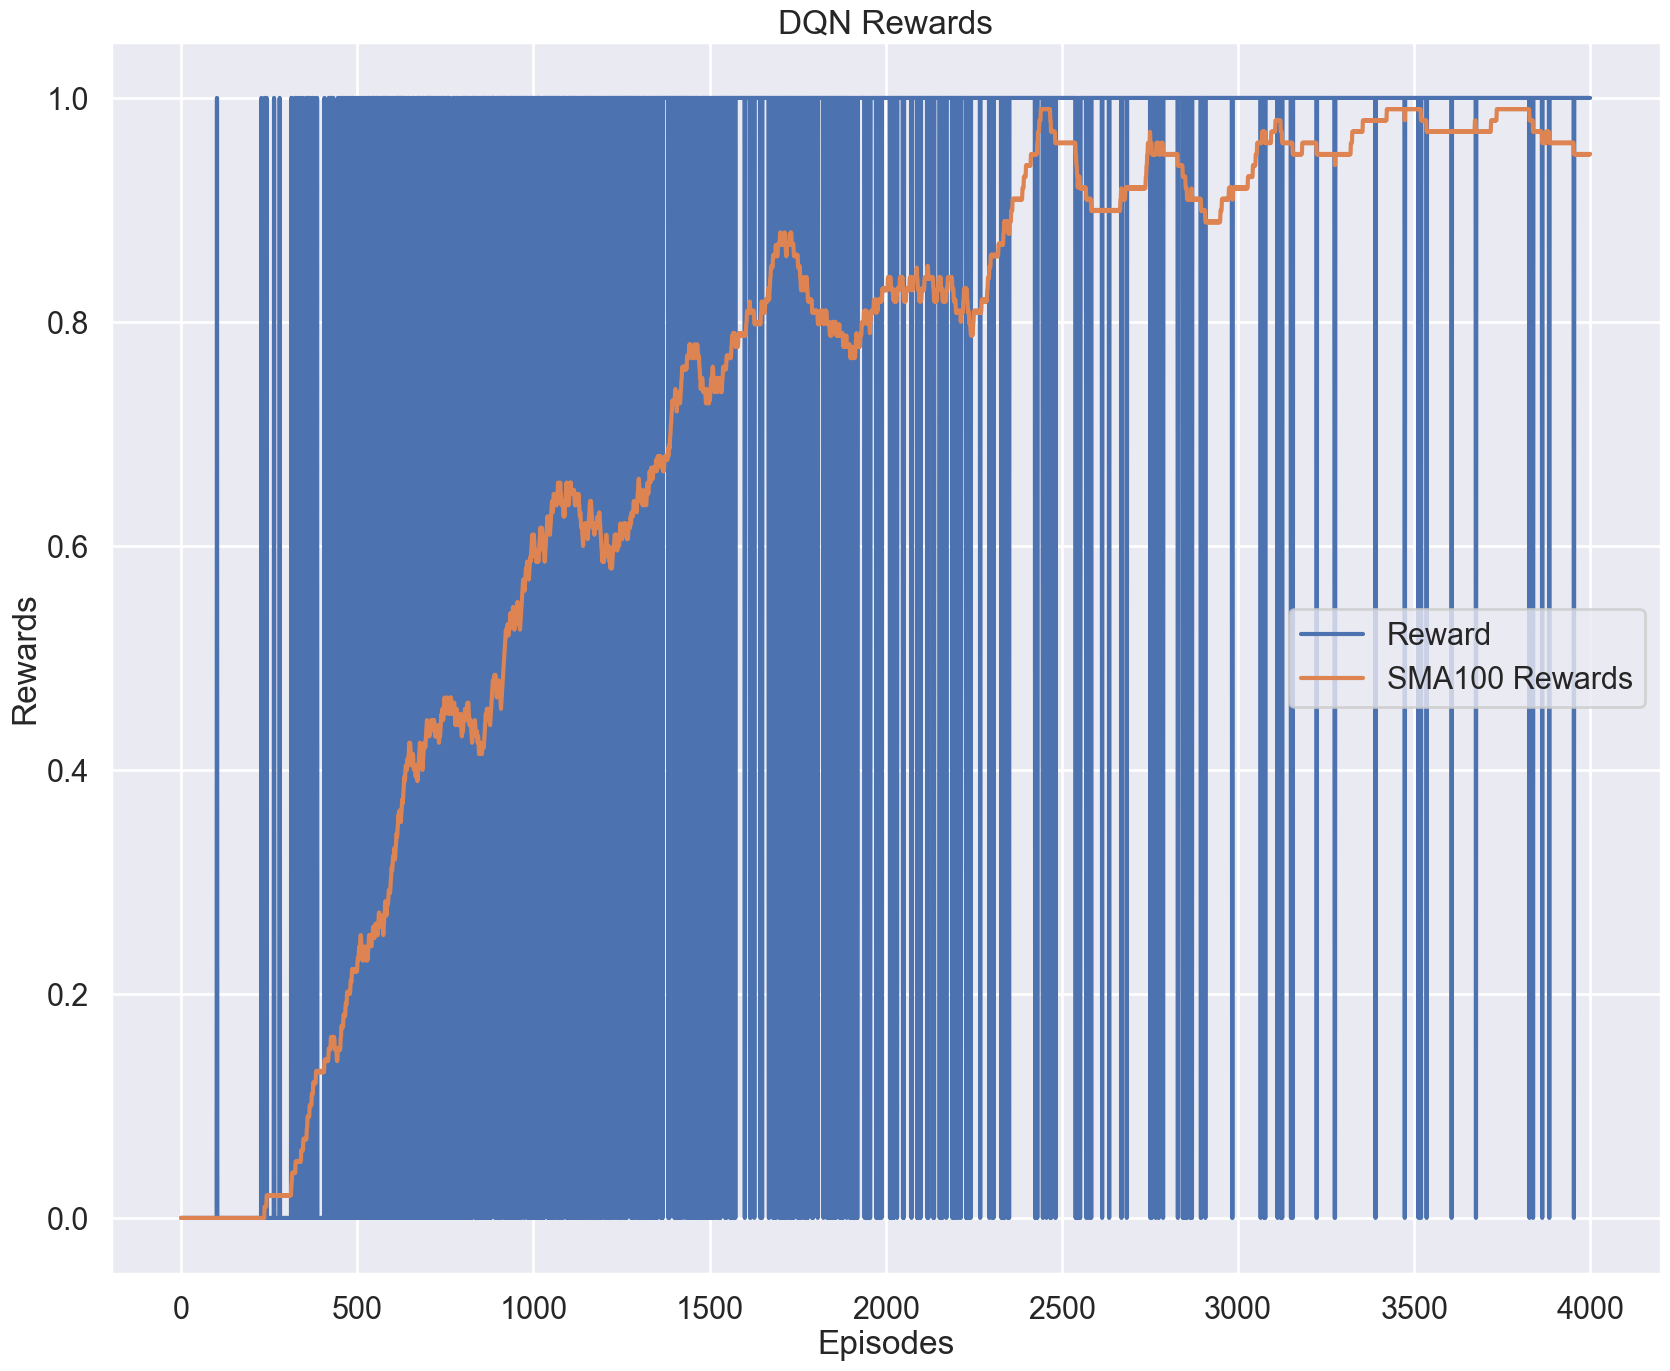

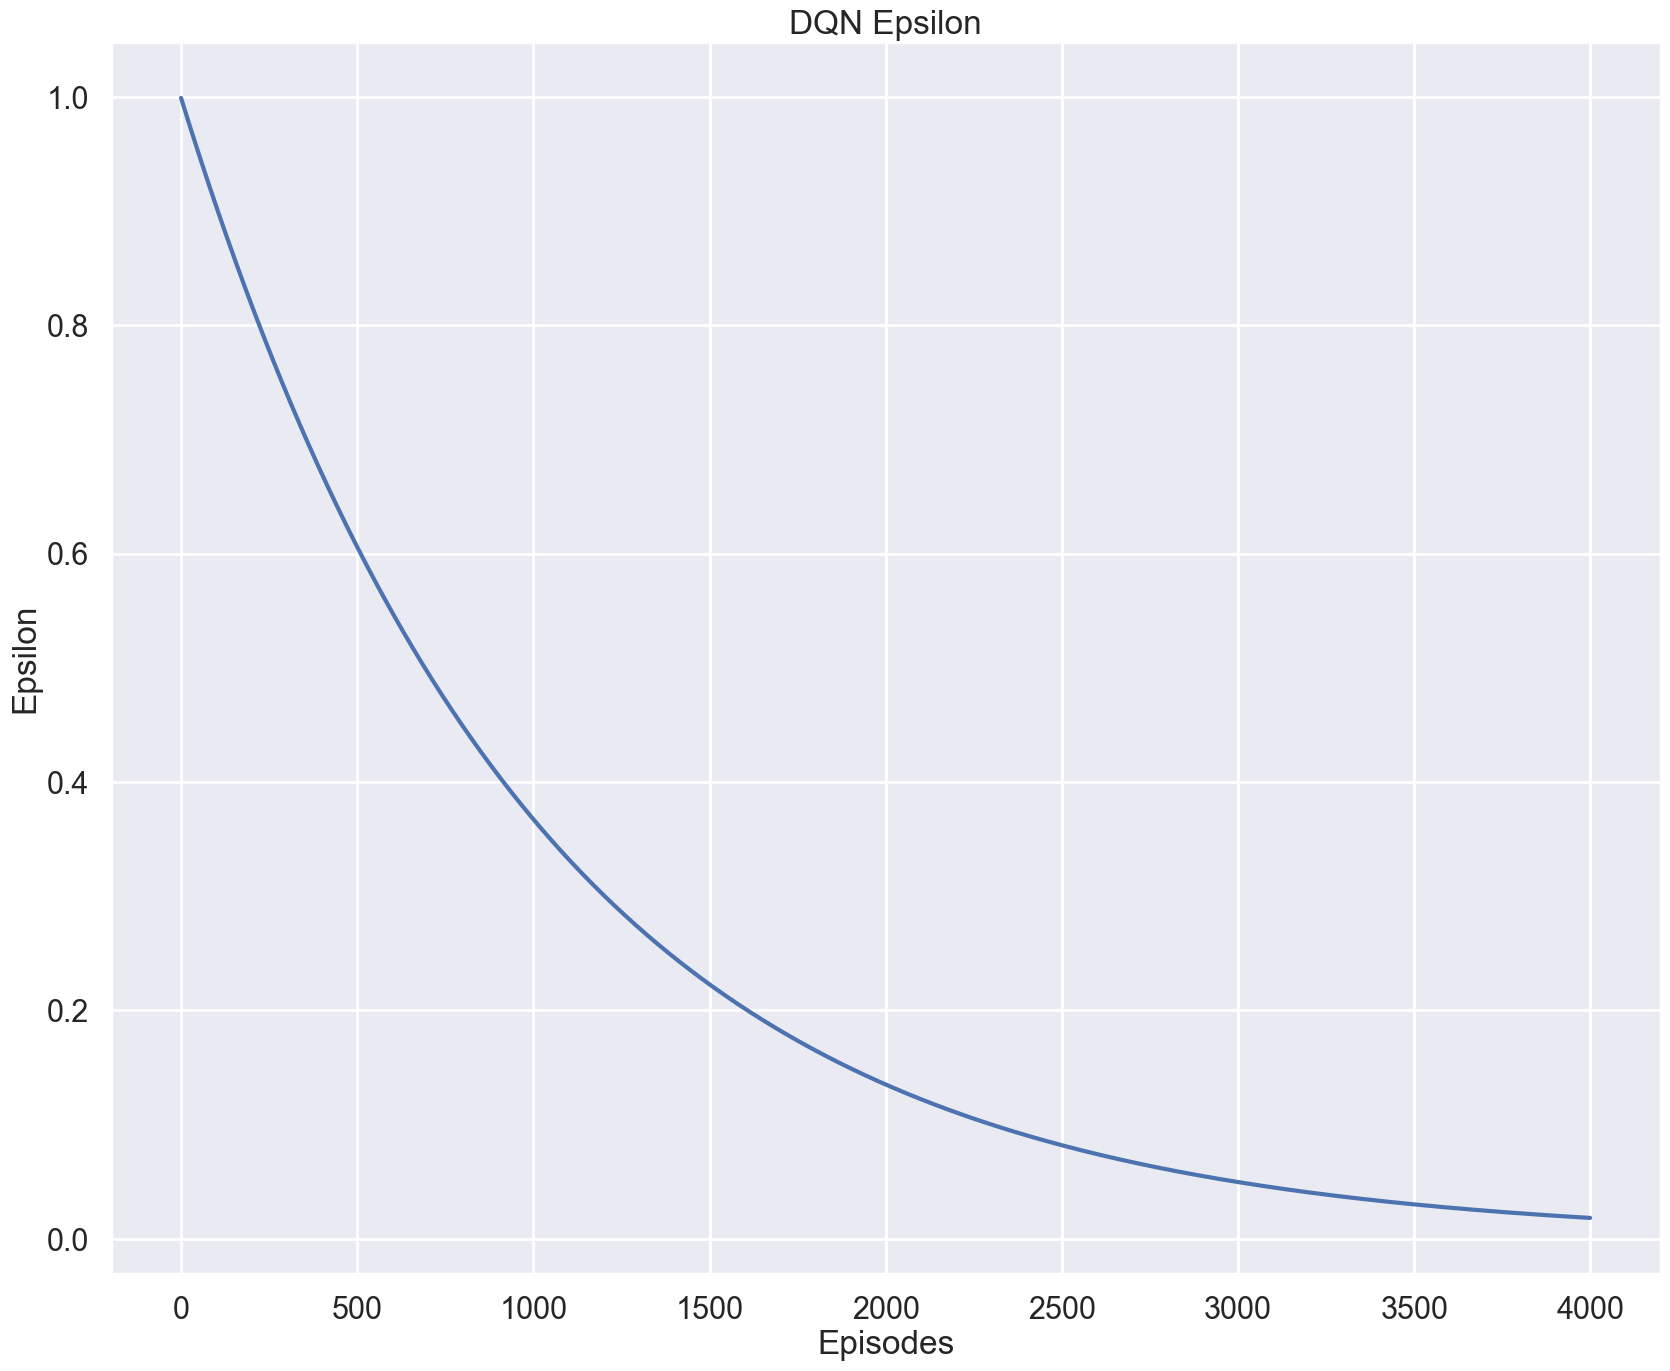

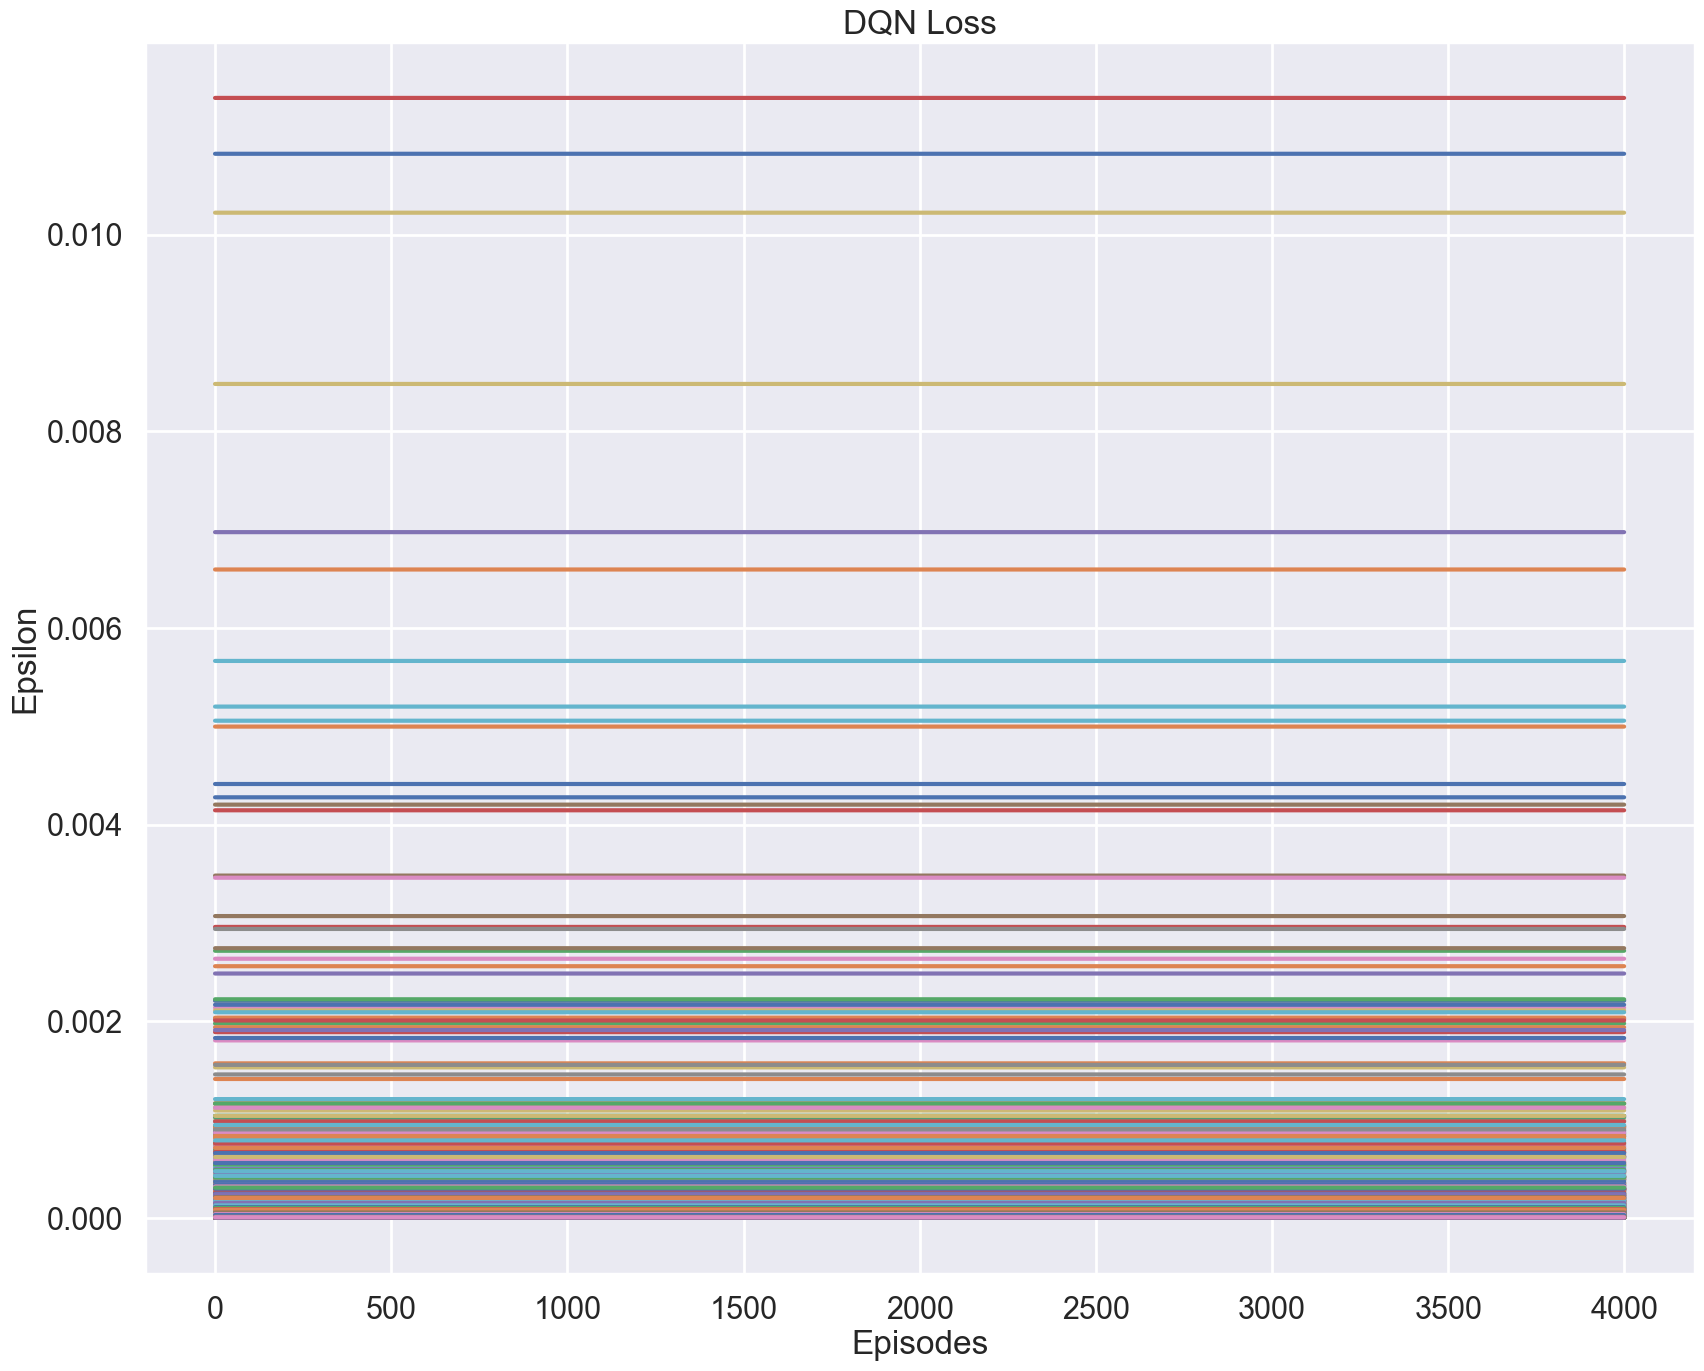

In [10]:
if __name__ == "__main__":
    RL_hyperparams = {
        "number_of_experiments": 50,
        "num_episodes": 4000,
        "lr": 1e-4,
        "eps_start": 0.999,
        "eps_end": 0.01,
        "eps_decay": 0.999,
        "gamma": 0.93,
        "batch_size": 32,
        "target_update": 10,
        "random_seed": 42,
    }
    main(RL_hyperparams=RL_hyperparams)
